# Understand why OSM network is incorrect

In [141]:
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon, LineString, Point

import matplotlib.pyplot as plt

import re
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_columns', None)

In [142]:
G_OSM = nx.read_gpickle('data/OSM_florida_G.plk')

G_OSM_tot = nx.read_gpickle('data/OSM_florida_G_non_simplified.plk')

In [143]:
def clean_graph(G):
    nodes, edges = ox.graph_to_gdfs(G)
    
    edges = edges.drop(edges.columns.difference(['length','geometry','u', 'v', 'key','duration','maxspeed']), axis=1)
    G = ox.graph_from_gdfs(nodes, edges)
    return G

In [144]:
G_OSM = clean_graph(G_OSM)
G_OSM_tot = clean_graph(G_OSM_tot)

G_osm_u = G_OSM.to_undirected()
G_osm_tot_u = G_OSM_tot.to_undirected()

In [145]:
hwy_dest = (25.760534, -80.489752)
hwy_ori = (25.912947, -81.368603) 

For this theses origin and arrival google maps predicts:
* Distance 91 km (57 miles)
* Duration 1 h

In [146]:
def path_length(G, path_nodes, weigth = 'length'):
    dist = [G.edges[path_nodes[i],path_nodes[i+1],0][weigth] for i in range(len(path_nodes)-1)]
    return sum(dist)

def get_route(G,orig,dest,weight='duration',orig_dest_size=100,algo='astar'):
    
    node_orig,dist_orig = ox.distance.get_nearest_node(G, orig, method='haversine', return_dist=True)
    node_dest,dist_dest = ox.distance.get_nearest_node(G, dest, method='haversine', return_dist=True)
    
    if algo == 'astar':
        dist_path = nx.astar_path_length(G, node_orig, node_dest, weight=weight)
        shortest_path_nx = nx.astar_path(G, node_orig, node_dest, weight=weight)
        
    elif algo == 'dijkstra':
        dist_path = nx.dijkstra_path_length(G, node_orig, node_dest, weight=weight)
        shortest_path_nx = nx.dijkstra_path(G, node_orig, node_dest, weight=weight)
        
    else:
        raise AssertionError(f'The parameter "algo" can either be "astar" or "dijkstra", not {algo}')
    
    distance_highway = path_length(G,shortest_path_nx)
    
    dist_non_highway = dist_orig + dist_dest
    
    total_dist =  dist_non_highway + distance_highway
    
    fig, ax = plt.subplots(figsize=(15, 7))
   
    ax.scatter(orig[1],orig[0],marker='x',s=orig_dest_size,zorder=5)
    ax.scatter(dest[1],dest[0],marker='x',s=orig_dest_size,zorder=10)
    ox.plot_graph(G, edge_color="#bfbfbf", node_color="#595959",bgcolor="w",ax=ax, show=False)
    ox.plot.plot_graph_route(G, shortest_path_nx, route_color='g', route_linewidth=4, route_alpha=0.9, orig_dest_size=100,ax=ax)
    
    if weight=='length':
        
        print(f'Distance {dist_path/1000} [km]')
        
    if weight=='duration':
        if dist_path>1:
            print(f'Duration {dist_path} [h] \nDistance {total_dist/1000} [km]')
            
        else:
            print(f'Duration {dist_path*60} [min] \nDistance {total_dist/1000} [km]')
    
    else:
        print(f'{str(weight)}: {dist_path/1000}')
        
    return node_orig, node_dest
              

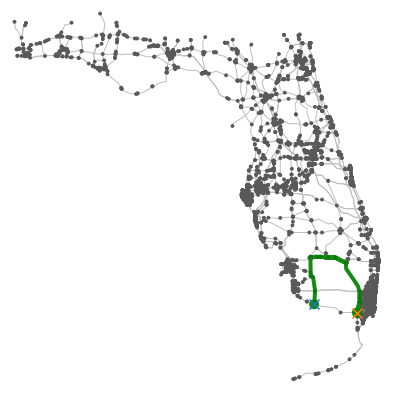

Duration 3.4251387988020334 [h] 
Distance 284.1265855781352 [km]


(302, 43233)

In [147]:
get_route(G_osm_u,hwy_ori,hwy_dest,weight='duration')

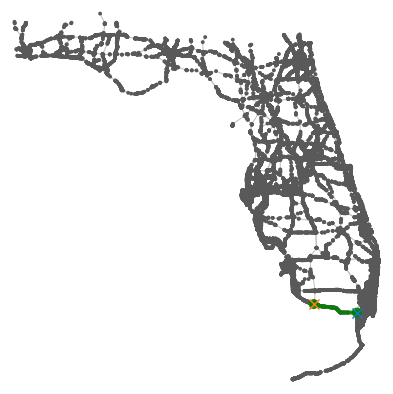

Duration 1.0147275082395077 [h] 
Distance 93.51773033456824 [km]


(43233, 25687)

In [148]:
get_route(G_osm_tot_u,hwy_dest,hwy_ori,weight='duration')

In [149]:
edges = ox.graph_to_gdfs(G_osm_u, nodes=False)
nodes = ox.graph_to_gdfs(G_osm_u, edges=False)

In [150]:
edges_tot = ox.graph_to_gdfs(G_osm_tot_u, nodes=False)
nodes_tot = ox.graph_to_gdfs(G_osm_tot_u, edges=False)

<AxesSubplot:>

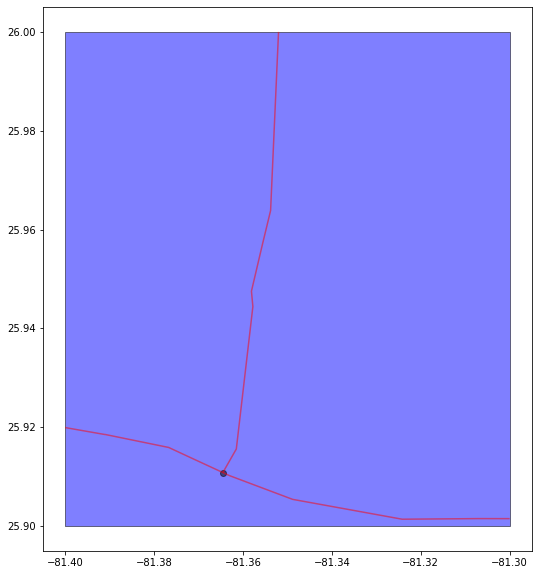

In [151]:
north, south, east, west = 26,25.9,-81.3,-81.4

polygon = Polygon([(west, south), (west, north), (east, north), (east, south)])

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_america = world[world["name"] == "United States of America"]

fig, ax = plt.subplots(figsize=(17,10))

bgmap = gpd.clip(n_america, polygon)
bgmap.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)

edges_clipped = gpd.clip(edges, polygon)
edges_clipped.plot(ax=ax, color="red",alpha=0.5)

nodes_clipped = gpd.clip(nodes, polygon)
nodes_clipped.plot(ax=ax, color="black",alpha=0.5)

The problem arises here: 3 roads should be visible, instead only two roads are visible. Thus the node (302) we are seeing is considered as beeing a sink node from the (187) edge.

* Assumption: <br>
This may be the fact because when filtering the osm.pbf data, only the highways were selected, thus the juntions between the highways were not considered. 


In [152]:
edges_clipped

,maxspeed,length,geometry,duration,u,v,key
187,53.333333,26271.474,"LINESTRING (-81.36453 25.91082, -81.36150 25.9...",0.306081,302,32964,0
3992,57.500000,74411.005,"LINESTRING (-81.40000 25.91994, -81.39115 25.9...",0.804119,25562,46969,0


In [153]:
nodes_clipped

,y,x,osmid,geometry
302,25.910824,-81.364528,"(-81.3645284, 25.9108242)",POINT (-81.36453 25.91082)


<AxesSubplot:>

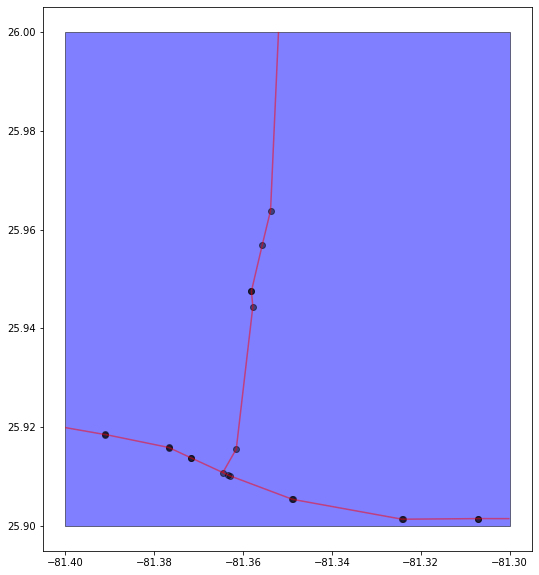

In [154]:
fig, ax = plt.subplots(figsize=(17,10))

bgmap = gpd.clip(n_america, polygon)
bgmap.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)

edges_tot_clipped = gpd.clip(edges_tot, polygon)
edges_tot_clipped.plot(ax=ax, color="red",alpha=0.5)

nodes_tot_clipped = gpd.clip(nodes_tot, polygon)
nodes_tot_clipped.plot(ax=ax, color="black",alpha=0.5)

In [155]:
edges_tot_clipped

,maxspeed,length,geometry,duration,u,v,key
608,45.0,611.642,"LINESTRING (-81.36453 25.91082, -81.36150 25.9...",0.008446,302,14453,0
19144,45.0,344.696,"LINESTRING (-81.35777 25.94441, -81.35809 25.9...",0.004760,14450,28522,0
19145,55.0,3225.239,"LINESTRING (-81.35777 25.94441, -81.36150 25.9...",0.036438,14450,14453,0
19149,55.0,807.498,"LINESTRING (-81.35568 25.95679, -81.35379 25.9...",0.009123,14454,14462,0
19150,45.0,1049.035,"LINESTRING (-81.35568 25.95679, -81.35808 25.9...",0.014485,14454,28523,0
19152,60.0,19863.483,"LINESTRING (-81.35200 26.00000, -81.35379 25.9...",0.205710,14455,14462,0
30576,60.0,1544.509,"LINESTRING (-81.40000 25.91994, -81.39115 25.9...",0.015995,25538,25587,0
30586,60.0,1453.943,"LINESTRING (-81.39096 25.91853, -81.37672 25.9...",0.015057,25543,25584,0
30587,60.0,18.827,"LINESTRING (-81.39096 25.91853, -81.39115 25.9...",0.000195,25543,25587,0
30600,60.0,1029.400,"LINESTRING (-81.30000 25.90151, -81.30703 25.9...",0.010661,25550,25700,0


In [156]:
nodes_tot_clipped

,y,x,osmid,geometry
302,25.910824,-81.364528,"(-81.3645284, 25.9108242)",POINT (-81.36453 25.91082)
14450,25.944413,-81.357774,"(-81.3577739, 25.9444133)",POINT (-81.35777 25.94441)
14453,25.915602,-81.361498,"(-81.3614982, 25.9156021)",POINT (-81.36150 25.91560)
14454,25.956786,-81.355682,"(-81.3556819, 25.956786)",POINT (-81.35568 25.95679)
14462,25.963845,-81.353787,"(-81.3537874, 25.9638454)",POINT (-81.35379 25.96385)
25543,25.918533,-81.390960,"(-81.3909601, 25.9185325)",POINT (-81.39096 25.91853)
25584,25.915913,-81.376717,"(-81.3767171, 25.915913)",POINT (-81.37672 25.91591)
25587,25.918543,-81.391148,"(-81.391148, 25.9185428)",POINT (-81.39115 25.91854)
25588,25.910338,-81.363333,"(-81.363333, 25.9103376)",POINT (-81.36333 25.91034)
25593,25.901392,-81.324184,"(-81.3241842, 25.901392)",POINT (-81.32418 25.90139)


<AxesSubplot:>

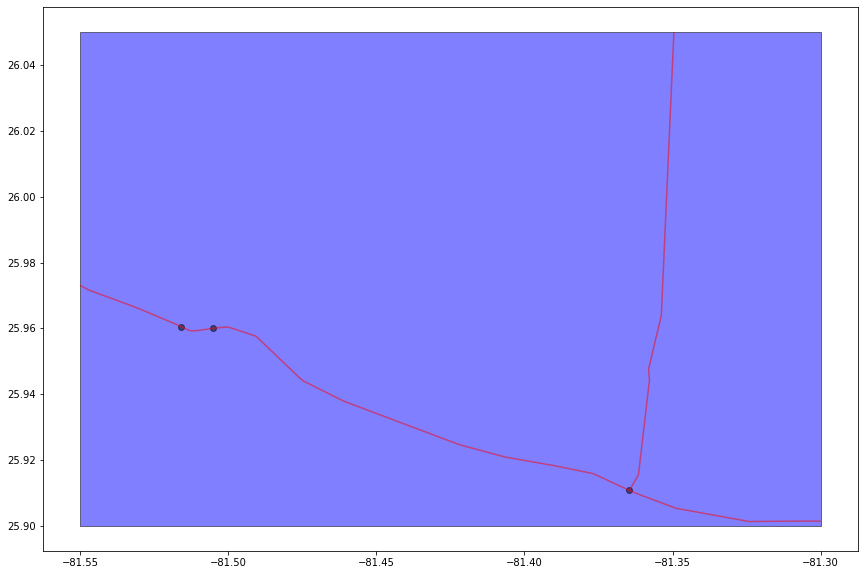

In [157]:
north, south, east, west = 26.05,25.9,-81.3,-81.55

polygon = Polygon([(west, south), (west, north), (east, north), (east, south)])

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_america = world[world["name"] == "United States of America"]

fig, ax = plt.subplots(figsize=(17,10))

bgmap = gpd.clip(n_america, polygon)
bgmap.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)

edges_clipped = gpd.clip(edges, polygon)
edges_clipped.plot(ax=ax, color="red",alpha=0.5)

nodes_clipped = gpd.clip(nodes, polygon)
nodes_clipped.plot(ax=ax, color="black",alpha=0.5)

In [158]:
edges_clipped

,maxspeed,length,geometry,duration,u,v,key
187,53.333333,26271.474,"LINESTRING (-81.36453 25.91082, -81.36150 25.9...",0.306081,302,32964,0
3991,60.000000,1100.026,"LINESTRING (-81.51582 25.96058, -81.51441 25.9...",0.011392,25562,25569,0
3992,57.500000,74411.005,"LINESTRING (-81.50519 25.96003, -81.50456 25.9...",0.804119,25562,46969,0
3993,60.000000,15577.773,"LINESTRING (-81.51582 25.96058, -81.51638 25.9...",0.161326,25569,33974,0


In [159]:
nodes_clipped

,y,x,osmid,geometry
302,25.910824,-81.364528,"(-81.3645284, 25.9108242)",POINT (-81.36453 25.91082)
25562,25.960034,-81.505191,"(-81.5051907, 25.960034)",POINT (-81.50519 25.96003)
25569,25.960582,-81.515816,"(-81.5158159, 25.960582)",POINT (-81.51582 25.96058)


<AxesSubplot:>

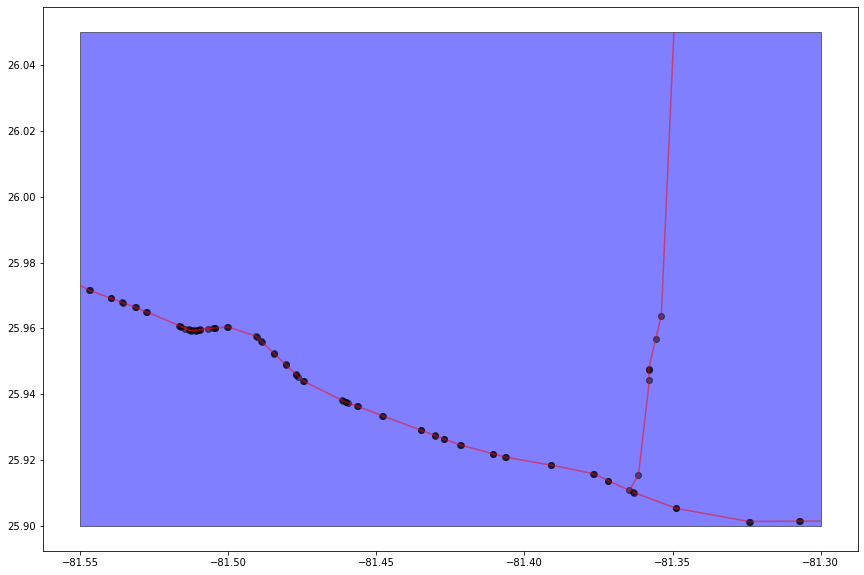

In [160]:
fig, ax = plt.subplots(figsize=(17,10))

bgmap = gpd.clip(n_america, polygon)
bgmap.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)

edges_tot_clipped = gpd.clip(edges_tot, polygon)
edges_tot_clipped.plot(ax=ax, color="red",alpha=0.5)

nodes_tot_clipped = gpd.clip(nodes_tot, polygon)
nodes_tot_clipped.plot(ax=ax, color="black",alpha=0.5)

In [161]:
edges_tot_clipped

,maxspeed,length,geometry,duration,u,v,key
608,45.0,611.642,"LINESTRING (-81.36453 25.91082, -81.36150 25.9...",0.008446,302,14453,0
19144,45.0,344.696,"LINESTRING (-81.35777 25.94441, -81.35809 25.9...",0.004760,14450,28522,0
19145,55.0,3225.239,"LINESTRING (-81.35777 25.94441, -81.36150 25.9...",0.036438,14450,14453,0
19149,55.0,807.498,"LINESTRING (-81.35568 25.95679, -81.35379 25.9...",0.009123,14454,14462,0
19150,45.0,1049.035,"LINESTRING (-81.35568 25.95679, -81.35808 25.9...",0.014485,14454,28523,0
...,...,...,...,...,...,...,...
30742,60.0,110.395,"LINESTRING (-81.51336 25.95970, -81.51228 25.9...",0.001143,25695,30290,0
30743,60.0,99.265,"LINESTRING (-81.47707 25.94600, -81.47635 25.9...",0.001028,25698,28116,0
33054,45.0,11.330,"LINESTRING (-81.35809 25.94750, -81.35808 25.9...",0.000156,28522,28523,0
34589,60.0,109.186,"LINESTRING (-81.51228 25.95952, -81.51118 25.9...",0.001131,30290,30291,0


In [162]:
nodes_tot_clipped

,y,x,osmid,geometry
302,25.910824,-81.364528,"(-81.3645284, 25.9108242)",POINT (-81.36453 25.91082)
14450,25.944413,-81.357774,"(-81.3577739, 25.9444133)",POINT (-81.35777 25.94441)
14453,25.915602,-81.361498,"(-81.3614982, 25.9156021)",POINT (-81.36150 25.91560)
14454,25.956786,-81.355682,"(-81.3556819, 25.956786)",POINT (-81.35568 25.95679)
14462,25.963845,-81.353787,"(-81.3537874, 25.9638454)",POINT (-81.35379 25.96385)
...,...,...,...,...
28523,25.947601,-81.358078,"(-81.3580779, 25.9476011)",POINT (-81.35808 25.94760)
30290,25.959520,-81.512275,"(-81.5122751, 25.9595204)",POINT (-81.51228 25.95952)
30291,25.959526,-81.511183,"(-81.511183, 25.9595264)",POINT (-81.51118 25.95953)
30292,25.959445,-81.513298,"(-81.5132977, 25.9594453)",POINT (-81.51330 25.95945)


# Test 2 


In [163]:
hwy_dest = (25.382380, -80.475159)
hwy_ori =(30.439440, -85.057166)

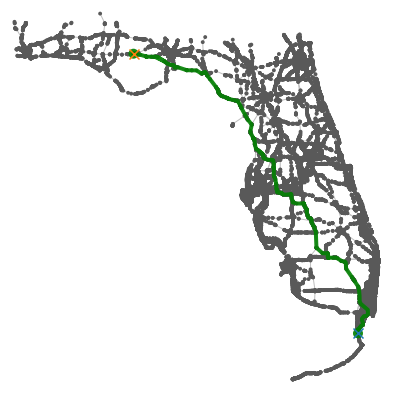

Duration 9.728563732495402 [h] 
Distance 884.4347038336603 [km]
Time: 7.545344114303589 s


In [164]:
import time
start = time.time()
get_route(G_osm_tot_u,hwy_dest,hwy_ori,weight='duration')
print(f'Time: {time.time()-start} s')
